# Spring 2023 SSMIF Quant Coding Challenge Question: Machine Learning

#### Name: Zakariyya Scavotto

#### Date: Last Updated 3_7_23, Downloaded 3_1_23

In [263]:
# Libraries (feel free to add more)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Neural network libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


# sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


## Part 1: Exploratory Data Analysis & Preprocessing

You will be working with `ml_data.csv` which is in time series format. Start by loading the data into a pandas DataFrame and performing some exploratory data analysis, preprocessing, normalization/standardization, etc. Feel free to utilize feature engineering techniques to improve the performance of your model. Insightful visuals are a plus.

**Note: if you decide to feature engineer, make sure to include these calculations in the pipeline. If you do not, the model will not work on our test set and your submission will not be scored.*

Step 1, Preliminary analysis and experimenting before processing:
I first decided to do preliminary visualization of the data to understand how the data is distributed/shaped, as well as correlated, before doing any major preprocessing and cleaning of the data.

In [264]:
# Read in the data the from csv file
# Don't need the first index column, so will exclude it by selecting only Feature1-10 and Target column to work with when reading in the data from the csv file
df = pd.read_csv('ml_data.csv', usecols=['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Feature9','Feature10','Target'])
# See what each column looks like by looking at the head of the DataFrame
print('DATA HEAD')
print(df.head()) # Columns: Feature1 Feature2 Feature3 Feature4 Feature5 Feature6 Feature7 Feature8 Feature9 Feature10 Target

# Check data types now to make sure there are no miscellaneous strings or objects that will throw off computations later in the code
print('\nDATA TYPES')
print(df.dtypes) # all are float64 which is good, no need to convert data types

# Check for NaN values, since they require addressing in data preprocessing (or else they will throw off computations)
print('\nNaN VALUES')
df.isna().sum() #  0, 0, 0, 0, 0, 0, 0, 0, 2901, 2901, 0

DATA HEAD
   Feature1  Feature2  Feature3   Feature4  Feature5  Feature6  Feature7  \
0     32.53     65.25    143.52  344403.32       0.0      91.0    2232.0   
1     32.51     14.64    143.47  342850.65       0.0      94.0    2222.0   
2     32.49    162.09    143.43  341297.97       0.0      94.0    2212.0   
3     32.49    195.61    143.43  343638.49       0.0      98.0    2228.0   
4     32.43    279.26    143.43  345192.38       0.0      99.0    2240.0   

   Feature8  Feature9  Feature10  Target  
0     9.579       NaN        NaN  243.93  
1     9.157       NaN        NaN  242.79  
2     8.735       NaN        NaN  241.65  
3     8.312       NaN        NaN  243.34  
4     7.890       NaN        NaN  244.62  

DATA TYPES
Feature1     float64
Feature2     float64
Feature3     float64
Feature4     float64
Feature5     float64
Feature6     float64
Feature7     float64
Feature8     float64
Feature9     float64
Feature10    float64
Target       float64
dtype: object

NaN VALUES


Feature1        0
Feature2        0
Feature3        0
Feature4        0
Feature5        0
Feature6        0
Feature7        0
Feature8        0
Feature9     2901
Feature10    2901
Target          0
dtype: int64

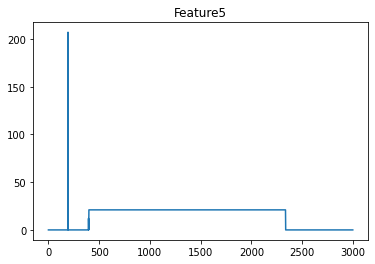

In [265]:
# Method to plot single features/target to get the general feel for the shape of the data in each column

def plotFeature(feature):
    df[feature].plot(title=feature)

# Feel free to uncomment any one of the method calls to see the graph generated
# plotFeature('Feature1') # Very sporadic feature with two steep spikes at around 1200, 2100. Sinusoidal probably, jumps/impulses outliers?
# plotFeature('Feature2') # Very noisy feature, random walk possibly?
# plotFeature('Feature3') # Feature that moves in a very stepwise manner, almost has exponential shape to it, spike downward around 1900
# plotFeature('Feature4') # Feature with exponential shape similar to feature 3, similar spike downward around 1900
plotFeature('Feature5') # Very weird feature, huge spike at around 200, then moves in a very boxy manner, moves up at 450, stays, then back down around 2250
# plotFeature('Feature6') # Very noisy feature similar to 2, another random walk?
# plotFeature('Feature7') # Feature with exponential like trend, similar to 3 and 4
# plotFeature('Feature8') # Feature that stays relatively flat just over 0 till it dips down at 2500, then spikes all the way up, then back down, economy shutdown and rebound from COVID recession?
# plotFeature('Feature9') # Currently is missing many values, haven't handled NaNs yet at this point in the code
# plotFeature('Feature10') # Currently is missing many values, haven't handled NaNs yet at this point in the code
# plotFeature('Target') # Has exponential trend to it, similar to features 3, 4, 7 in that sense (S&P 500 over time?)


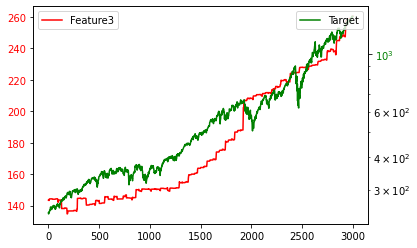

In [266]:
'''Method to plot two features on one graph to get an idea of how similar different features are to each other 
or one feature to the target''';
def plotRelationships(feature1, feature2):
    # Create subplot structure, and plot the first feature on one axis
    fig, ax = plt.subplots()
    ax.plot(df[feature1], label = feature1, color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Creates a twin y-axis that shares the x axis, which will be used to plot the other feature, and plot the other feature
    ax2 = ax.twinx()
    ax2.plot(df[feature2],label=feature2, color='green')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Add legends to the plot, and put them in different spots to prevent overlap
    ax.legend()
    ax2.legend(loc = 'upper right')

plotRelationships('Feature3','Target')

In [267]:
# Code cell to handle NAN Values
'''Looking through CSV file, features 9 and 10 are missing a lot of values (in the same rows coincidentally enough)

    Considering that Feature9 is a number that increases every 31 rows until it hits 128, could be an indicator of something
    happening over time and it's the period of time (month count? something like that)
    
    Feature10 seems to fluctuate up and down over time, which could prove to provide useful information
    
    For both of these features, to fix the gaps in the data, I want to try interpolating the data so that I don't throw away
    possible key information''';


df['Feature9']=df['Feature9'].interpolate(method='linear', limit_direction='both')
df['Feature10']=df['Feature10'].interpolate(method='linear', limit_direction='both')
# Now, there are no missing values in the DataFrame
df.isna().sum() 

Feature1     0
Feature2     0
Feature3     0
Feature4     0
Feature5     0
Feature6     0
Feature7     0
Feature8     0
Feature9     0
Feature10    0
Target       0
dtype: int64

Now that the two features have been interpolated, we can take a look at their graphs

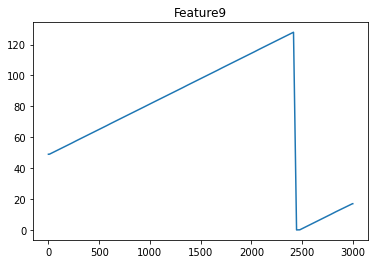

In [268]:
plotFeature("Feature9") # Noooooo it's the days since last recession data!!! This is gonna be fun :)

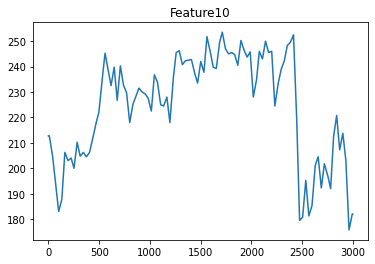

In [269]:
plotFeature("Feature10") # I have no clue what this might represent... seems to be very sporadic

In [270]:
# Correlation matrix analysis time!
'''Analysis:
    Feature1 doesn't seem highly correlated with other features or the target
    Feature2 doesn't seem highly correlated with other features or the target
    Feature3 is highly correlated with Feature4 (as predicted by looking at graphs), a bit less correlated with Feature7, 
        and highly correlated with Target so need to be a bit weary of overfitting
    Feature4 is highly correlated with Feature3, extremely correlated with Feature7 and Target, 
        again need to be concerned about overfitting
    Feature5's notable aspect correlation-wise is that it has moderate negative correlations with a lot of features,
        correlation with Feature9 and Feature10, need to be weary about overfitting
    Feature6 has very little correlation with anything, which makes sense given its erratic graph 
    Feature7 is highly correlated with features 3 and 4, as well as the target, need to be careful about overfitting
    Feature8 has very little positive or negative correlation with anything, expected from seeing the graph of it
    Feature9 has some negative correlation with features 4 and 7, strong correlation with feature 10 (is that due to the interpolation?),
        moderate negative correlation with the target
    Feature10 has correlation with Feature9 (interpolation again?), decent correlation with Feature5
    
    Target: If features 3,4,7 are too highly weighted in the model picked, could lead to some serious overfitting,
        need to be aware of this possibility
''';
corr = df.corr()
corr

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Target
Feature1,1.000000,-0.005021,0.121776,0.144631,-0.162565,0.004197,0.094473,0.032583,-0.169282,-0.213064,0.155877
Feature2,-0.005021,1.000000,0.023991,0.023849,0.017478,0.010487,0.025487,-0.001376,0.013282,0.031408,0.021894
Feature3,0.121776,0.023991,1.000000,0.889713,-0.383276,0.001235,0.822711,0.060885,-0.283381,-0.199037,0.945929
Feature4,0.144631,0.023849,0.889713,1.000000,-0.382642,-0.000276,0.969135,0.187291,-0.411148,-0.227971,0.983673
Feature5,-0.162565,0.017478,-0.383276,-0.382642,1.000000,0.002830,-0.414274,-0.011551,0.687783,0.719641,-0.434002
Feature6,0.004197,0.010487,0.001235,-0.000276,0.002830,1.000000,0.001417,-0.009238,-0.006960,-0.000596,-0.000523
Feature7,0.094473,0.025487,0.822711,0.969135,-0.414274,0.001417,1.000000,0.215727,-0.486555,-0.267342,0.951220
Feature8,0.032583,-0.001376,0.060885,0.187291,-0.011551,-0.009238,0.215727,1.000000,-0.018620,0.062043,0.162651
Feature9,-0.169282,0.013282,-0.283381,-0.411148,0.687783,-0.006960,-0.486555,-0.018620,1.000000,0.858250,-0.427272
Feature10,-0.213064,0.031408,-0.199037,-0.227971,0.719641,-0.000596,-0.267342,0.062043,0.858250,1.000000,-0.276040


Step 2: Preprocessing the data 

After the preliminary visual and correlatiion analysis to determine the distribution of the data, I then proceeded to get the data ready for training by the ML models I were to use. To do this, I opted to standardize the data so that way no differences in the magnitude of the measurements in the data (ex: Feature1 is in the 30s while Feature3 is in the 100s) would affect how each feature is weighted in training. On some of the features and the target, I did something different aside from just using sklearn's StandardScaler, which I have detailed below:

Feature1: For this feature, due to the two jumps present in the data that are outliers, I decided to use a RobustScaler instead of the StandardScaler, since that utilizes the median and quartiles (less affected by outliers) to do the scaling than the standard scaler that uses the mean and standard deviation (more prone to substantial affect of outliers).

Feature5: Visually inspecting the data, I noticed that in the first step there was an outlier value in the 200s. So before I scaled that feature, I removed the outlier from the data (utilizing a conditional statement with pandas' mask method) and replaced it with a 0 to match the rest of that step.

Feature8: Similarly to Feature1, I noticed that there was the dip and surge back up in the data that presented outliers. Unlike Feature5 where this outlier is more akin to a bad data point, this outlier could have an actual effect on the data like Feature1's outliers. To this end, I followed a similar approach to the one I used for Feature1 where I used a RobustScaler to scale the data instead of the StandardScaler.

Target: I decided to scale the target since that helps the model with training and understanding the data, and when the features are scaled but the target isn't the error terms tend to be very high which could send the model in the completely wrong direction with any sort of gradient descent (or whatever approach a model uses) in training, leading to high error terms

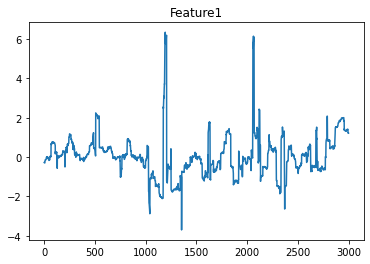

In [271]:
# Feature 1: Using sklearn's RobustScaler to try to not only scale the data for the NN, but also handle for outliers
feature1Scalar = RobustScaler()
feature1Data = df['Feature1'].to_numpy()
feature1DataScaled = feature1Scalar.fit_transform(feature1Data.reshape(-1,1))
feature1DataScaled = [item[0] for item in feature1DataScaled]
df['Feature1'] = feature1DataScaled
plotFeature("Feature1")

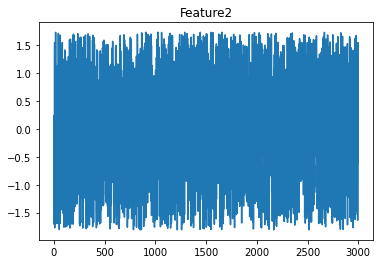

In [272]:
# Feature 2: Since the data needs to be scaled but there are no major outliers to control for (it's a random walk), standard scaler
feature2Scalar = StandardScaler()
feature2Data = df['Feature2'].to_numpy()
feature2DataScaled = feature2Scalar.fit_transform(feature2Data.reshape(-1,1))
feature2DataScaled = [item[0] for item in feature2DataScaled]
df['Feature2'] = feature2DataScaled
plotFeature("Feature2")

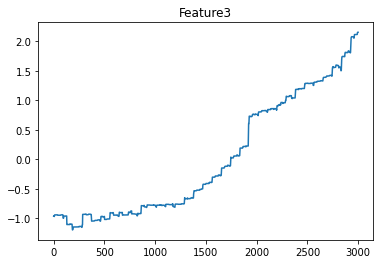

In [273]:
# Feature 3: using a standard scaler
feature3Scalar = StandardScaler()
feature3Data = df['Feature3'].to_numpy()
feature3DataScaled = feature3Scalar.fit_transform(feature3Data.reshape(-1,1))
feature3DataScaled = [item[0] for item in feature3DataScaled]
df['Feature3'] = feature3DataScaled
plotFeature("Feature3")

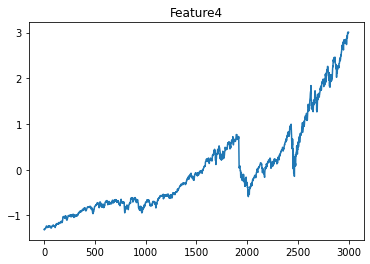

In [274]:
# Feature 4: using a standard scaler
feature4Scalar = StandardScaler()
feature4Data = df['Feature4'].to_numpy()
feature4DataScaled = feature4Scalar.fit_transform(feature4Data.reshape(-1,1))
feature4DataScaled = [item[0] for item in feature4DataScaled]
df['Feature4'] = feature4DataScaled
plotFeature("Feature4")

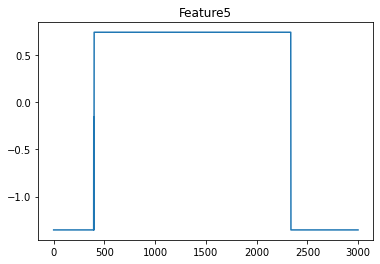

In [275]:
# Feature 5: remove outlier, then scale
df["Feature5"].mask(df["Feature5"] > 50, 0, inplace=True)
feature5Scalar = StandardScaler()
feature5Data = df['Feature5'].to_numpy()
feature5DataScaled = feature5Scalar.fit_transform(feature5Data.reshape(-1,1))
feature5DataScaled = [item[0] for item in feature5DataScaled]
df['Feature5'] = feature5DataScaled
plotFeature("Feature5")

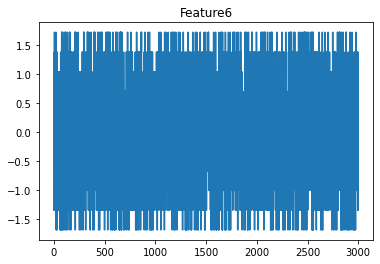

In [276]:
# Feature 6: Standard scaling
feature6Scalar = StandardScaler()
feature6Data = df['Feature6'].to_numpy()
feature6DataScaled = feature6Scalar.fit_transform(feature6Data.reshape(-1,1))
feature6DataScaled = [item[0] for item in feature6DataScaled]
df['Feature6'] = feature6DataScaled
plotFeature("Feature6")

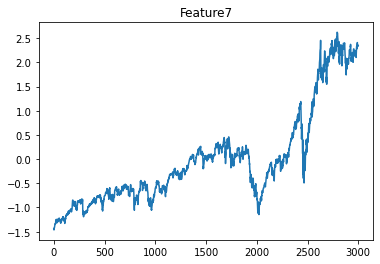

In [277]:
# Feature 7: using a standard scaler
feature7Scalar = StandardScaler()
feature7Data = df['Feature7'].to_numpy()
feature7DataScaled = feature7Scalar.fit_transform(feature7Data.reshape(-1,1))
feature7DataScaled = [item[0] for item in feature7DataScaled]
df['Feature7'] = feature7DataScaled
plotFeature("Feature7")

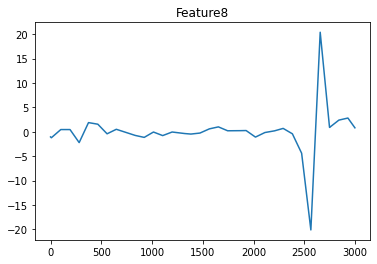

In [278]:
# Feature 8: Using sklearn's RobustScaler to scale the data while handling outliers
feature8Scalar = RobustScaler()
feature8Data = df['Feature8'].to_numpy()
feature8DataScaled = feature8Scalar.fit_transform(feature8Data.reshape(-1,1))
feature8DataScaled = [item[0] for item in feature8DataScaled]
df['Feature8'] = feature8DataScaled
plotFeature("Feature8")

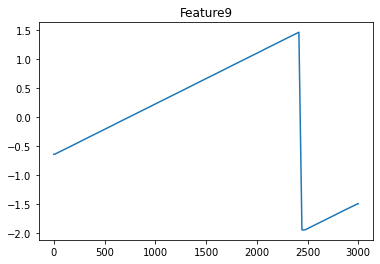

In [279]:
# Feature 9: using a standard scaler
feature9Scalar = StandardScaler()
feature9Data = df['Feature9'].to_numpy()
feature9DataScaled = feature9Scalar.fit_transform(feature9Data.reshape(-1,1))
feature9DataScaled = [item[0] for item in feature9DataScaled]
df['Feature9'] = feature9DataScaled
plotFeature("Feature9")

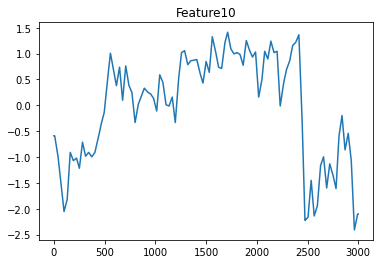

In [280]:
# Feature 10: using a standard scalar
feature10Scalar = StandardScaler()
feature10Data = df['Feature10'].to_numpy()
feature10DataScaled = feature10Scalar.fit_transform(feature10Data.reshape(-1,1))
feature10DataScaled = [item[0] for item in feature10DataScaled]
df['Feature10'] = feature10DataScaled
plotFeature("Feature10")

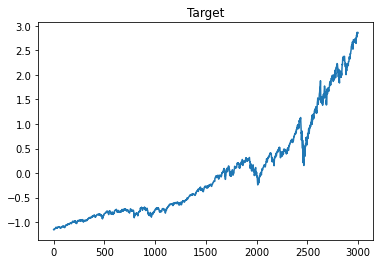

In [281]:
# Finally, scale the target to match the features being scaled
targetScalar = StandardScaler()
targetData = df['Target'].to_numpy()
targetDataScaled = targetScalar.fit_transform(targetData.reshape(-1,1))
targetDataScaled = [item[0] for item in targetDataScaled]
df['Target'] = targetDataScaled
plotFeature("Target")

In [282]:
# New correlation matrix! But it's the same because the shape of the data is preserved in the scaling!
corr = df.corr()
corr

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Target
Feature1,1.000000,-0.005021,0.121776,0.144631,-0.173834,0.004197,0.094473,0.032583,-0.169282,-0.213064,0.155877
Feature2,-0.005021,1.000000,0.023991,0.023849,0.008835,0.010487,0.025487,-0.001376,0.013282,0.031408,0.021894
Feature3,0.121776,0.023991,1.000000,0.889713,-0.398330,0.001235,0.822711,0.060885,-0.283381,-0.199037,0.945929
Feature4,0.144631,0.023849,0.889713,1.000000,-0.398497,-0.000276,0.969135,0.187291,-0.411148,-0.227971,0.983673
Feature5,-0.173834,0.008835,-0.398330,-0.398497,1.000000,0.002900,-0.432706,-0.012940,0.732256,0.770034,-0.453175
Feature6,0.004197,0.010487,0.001235,-0.000276,0.002900,1.000000,0.001417,-0.009238,-0.006960,-0.000596,-0.000523
Feature7,0.094473,0.025487,0.822711,0.969135,-0.432706,0.001417,1.000000,0.215727,-0.486555,-0.267342,0.951220
Feature8,0.032583,-0.001376,0.060885,0.187291,-0.012940,-0.009238,0.215727,1.000000,-0.018620,0.062043,0.162651
Feature9,-0.169282,0.013282,-0.283381,-0.411148,0.732256,-0.006960,-0.486555,-0.018620,1.000000,0.858250,-0.427272
Feature10,-0.213064,0.031408,-0.199037,-0.227971,0.770034,-0.000596,-0.267342,0.062043,0.858250,1.000000,-0.276040


## Part 2: Exploratory Model Training

Train a model of your choice on the data. Feel free to use any packages (`scikit-learn`, `TensorFlow`, `Keras`, `PyTorch`, etc.) you want to help. This section should show the process you used to get to your final model. Make sure to explain why you chose the model you did and the steps you took to train and optimize it.

I decided to try two models, first a neural network (NN), then a linear regression. I decided to try usuing a NN because of its ability to find hidden patterns in data that aren't immediately visible, while the linear regression is a very powerful regression model that can fit itself very well to data that is not only linear, but even exponential (like our target).

Originally, I ran these models before scaling the data in step 2 of the preprocessing, and as expected these results were not that great due to the varying magnitudes of the factors throwing off the training. After I implemented the scaling of features in the preprocessing, the models improved significantly.

In [283]:
# Split into 80% training, 20% testing
train=df.sample(frac=0.8,random_state=42) # Picked a random state to have more consistent results when testing the models
test=df.drop(train.index)

# Split the training and testing sets between X (the features) and Y (the target) 
xTrain = train.loc[:,train.columns != 'Target'].values  
yTrain = train.loc[:,train.columns == 'Target'].values
xTest  = test.loc[:,test.columns != 'Target'].values 
yTest = test.loc[:,test.columns == 'Target'].values
# I know that sklearn has train_test_split, but for working with dataframes I find it easier to sample from the dataframe like above

Epoch 1/100
10/10 [==============================] - 2s 70ms/step - loss: 10.9741 - val_loss: 0.7851
Epoch 2/100
10/10 [==============================] - 0s 36ms/step - loss: 0.6693 - val_loss: 0.9202
Epoch 2: early stopping
Train loss:  0.8152267336845398  Test loss:  0.9201703667640686


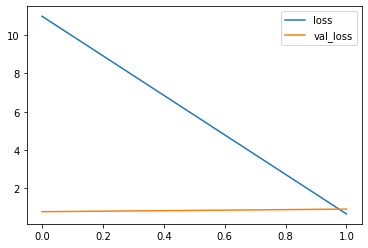

In [284]:
'''Regular NN with dense layers, BatchNormalization at the start and in between hidden layers to help keep things stable, 
    1 unit dense layer at end for output
    Used the RELU activation function since it is a fairly standard and robust (not sure if that's the right word) activation function''';
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', input_shape=[10]),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])
# Standard adam optimizer, using mse for loss since it's close to RMSE (just need to take the root of it to get RMSE)
model.compile(
    optimizer='adam',
    loss='mse',
)
# Adding early stopping so the model doesn't have to train the full number of epochs, and more importantly helps prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
    xTrain, yTrain,
    validation_data=(xTest, yTest),
    batch_size=256,
    epochs=100,
    verbose=1, # decided to make verbose to follow the training, feel free to set to 0
    callbacks=[es]
)
# Print final losses as a reference point
train_loss = model.evaluate(xTrain, yTrain, verbose=0)
test_loss = model.evaluate(xTest, yTest, verbose=0)
print('Train loss: ',train_loss, ' Test loss: ',test_loss)
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

RMSE:  0.05635612604319447
R^2:  0.9971215895097951


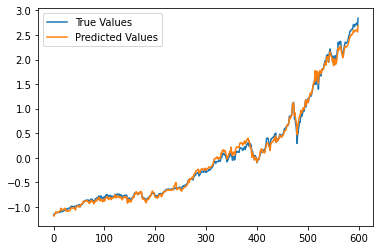

In [285]:
# Make a linear regression model, fit on training data, predict on testX
testModel = LinearRegression()
testModel.fit(xTrain, yTrain)
yPred = testModel.predict(xTest)

# Plot for comparison
plt.plot(yTest, label='True Values')
plt.plot(yPred, label = 'Predicted Values')
plt.legend()

# Get RMSE, R^2 as an indicator of "accuracy" in the regression
print('RMSE: ', mean_squared_error(yTest, yPred, squared=False))
print('R^2: ',r2_score(yTest, yPred))

As can be seen, the above linear regression is able to nearly perfectly predict the data set (almost concerningly so), featuring a R^2 of 0.997. While this is good within the scope of the dataset, the model is severely overfit, meaning that outside of the data given to the model in training, the model may not be able to extrapolate well. If this model were to be used for future forecasting beyond the given data, unless the future data follows a similar trend to the training data, the model would likely have to be altered in order to handle a change in trend and retrained.

On the other hand, the neural network is fairly accurate, but it is not so accurate that it perfectly predicts the training data and may not be able to extrapolate well, unlike the linear regression. This is exemplified by the fact that its training losses tend to be around 0.75-0.85, while its testing losses tend to be around 0.8-0.9 (it's "around" those ranges due to natural variation in model weights in training from run to run. I checked this by running the cell a few times, there are times where the network doesn't perform as well compared to other runs or performs too well but that's due to the randomness in weight initialization). Because of the early stopping, the model is able to stop training right at the moment it's about to become overfit (the validation loss increases while training loss decreases), shown in the graph of the losses when the model stops training around the point where the validation loss is greater than the training loss.

## Part 3: Final Model

Put your finalized model in this code block below. You may work in the class provided below or create your own. Editing the functions and adding your own functions to make your code run smoohtly is acceptable. It should compile and run using the following scripts:

(Note: you do not have access to these files, but it is how we will test your models)

```python
model = Model()
model.train("train_set.csv", ".")
model.test("test_set.csv", ".")
```

### Model chosen and why:
In the end, I opted to utilize a NN like the one I developed in part 2 of the challenge. I decided to go with the NN over the linear regression I created because while the linear regression may have been more accurate, it was also severely overfitting the training data, which is not what we would want this model to do if it were to be used outside of the training data set, which is what will be happening in this part of the problem. Additionally, because of how NNs find hidden patterns in data through training that linear regressions may not be able to do as well, the NN would likely work better when given new data that may not follow the same trend as the training data. For these reasons, I picked a NN as my final model over the linear regression. As shown by running the final model utilizing the data file we were provided, the RMSE is usually 0.8-1 (from my experience when I've run it). 


In [286]:

class Model:

    raw_data_X = None
    raw_data_y = None

    processed_data_X = None
    processed_data_Y = None

    model = None

    '''
    This function should take the provided raw data and preprocess it.
    This should be the finalized preprocessing process from Part 1.
    '''
    def __preprocess(self):
        #All preprocessing should be in here
        '''Note: I'm sure there is a way to make this method shorter than what it is currently by combining similar scaling operations
        on different columns into one, but it helps me to logically understand what is going on by having each one be its own little section'''
        # Process Feature1
        self.processed_data_X, self.processed_data_Y = pd.DataFrame(), pd.DataFrame()
        feature1Scalar = RobustScaler()
        feature1Data = self.raw_data_X['Feature1'].to_numpy()
        feature1DataScaled = feature1Scalar.fit_transform(feature1Data.reshape(-1,1))
        feature1DataScaled = [item[0] for item in feature1DataScaled]
        self.processed_data_X['Feature1'] = feature1DataScaled
        # Feature2
        feature2Scalar = StandardScaler()
        feature2Data = self.raw_data_X['Feature2'].to_numpy()
        feature2DataScaled = feature2Scalar.fit_transform(feature2Data.reshape(-1,1))
        feature2DataScaled = [item[0] for item in feature2DataScaled]
        self.processed_data_X['Feature2'] = feature2DataScaled
        # Feature3
        feature3Scalar = StandardScaler()
        feature3Data = self.raw_data_X['Feature3'].to_numpy()
        feature3DataScaled = feature3Scalar.fit_transform(feature3Data.reshape(-1,1))
        feature3DataScaled = [item[0] for item in feature3DataScaled]
        self.processed_data_X['Feature3'] = feature3DataScaled
        # Feature4
        feature4Scalar = StandardScaler()
        feature4Data = self.raw_data_X['Feature4'].to_numpy()
        feature4DataScaled = feature4Scalar.fit_transform(feature4Data.reshape(-1,1))
        feature4DataScaled = [item[0] for item in feature4DataScaled]
        self.processed_data_X['Feature4'] = feature4DataScaled
        # Feature5
        feature5Scalar = StandardScaler()
        feature5Data = self.raw_data_X['Feature5'].to_numpy()
        feature5DataScaled = feature5Scalar.fit_transform(feature5Data.reshape(-1,1))
        feature5DataScaled = [item[0] for item in feature5DataScaled]
        self.processed_data_X['Feature5'] = feature5DataScaled
        # Feature6
        feature6Scalar = StandardScaler()
        feature6Data = self.raw_data_X['Feature6'].to_numpy()
        feature6DataScaled = feature6Scalar.fit_transform(feature6Data.reshape(-1,1))
        feature6DataScaled = [item[0] for item in feature6DataScaled]
        self.processed_data_X['Feature6'] = feature6DataScaled
        # Feature7
        feature7Scalar = StandardScaler()
        feature7Data = self.raw_data_X['Feature7'].to_numpy()
        feature7DataScaled = feature7Scalar.fit_transform(feature7Data.reshape(-1,1))
        feature7DataScaled = [item[0] for item in feature7DataScaled]
        self.processed_data_X['Feature7'] = feature7DataScaled
        # Feature8
        feature8Scalar = RobustScaler()
        feature8Data = self.raw_data_X['Feature8'].to_numpy()
        feature8DataScaled = feature8Scalar.fit_transform(feature8Data.reshape(-1,1))
        feature8DataScaled = [item[0] for item in feature8DataScaled]
        self.processed_data_X['Feature8'] = feature8DataScaled
        '''Just in case, handle NaN values for Feature9, Feature10 in the event NaN data gets thrown in for those features
            (Note: I don't know why it gives the warning here but not in part 1, the pointers and copies are acting weirdly)'''
        self.raw_data_X['Feature9']=self.raw_data_X['Feature9'].interpolate(method='linear', limit_direction='both')
        self.raw_data_X['Feature10']=self.raw_data_X['Feature10'].interpolate(method='linear', limit_direction='both')
        # Feature9
        feature9Scalar = StandardScaler()
        feature9Data = self.raw_data_X['Feature9'].to_numpy()
        feature9DataScaled = feature9Scalar.fit_transform(feature9Data.reshape(-1,1))
        feature9DataScaled = [item[0] for item in feature9DataScaled]
        self.processed_data_X['Feature9'] = feature9DataScaled
        # Feature10
        feature10Scalar = StandardScaler()
        feature10Data = self.raw_data_X['Feature10'].to_numpy()
        feature10DataScaled = feature10Scalar.fit_transform(feature10Data.reshape(-1,1))
        feature10DataScaled = [item[0] for item in feature10DataScaled]
        self.processed_data_X['Feature10'] = feature10DataScaled
        # Target
        targetScalar = StandardScaler()
        targetData = self.raw_data_y['Target'].to_numpy()
        targetDataScaled = targetScalar.fit_transform(targetData.reshape(-1,1))
        targetDataScaled = [item[0] for item in targetDataScaled]
        self.processed_data_Y['Target'] = targetDataScaled

    '''
    This function should take preprocessed data and use it to train your model.
    This should be the finalized training process from Part 2.
    '''
    def __train_model(self):
        # Split processed train data into train and validation
        trainingDF = pd.concat([self.processed_data_X, self.processed_data_Y], axis = 1)
        train= trainingDF.sample(frac=0.8)
        test=trainingDF.drop(train.index)
        xTrain = train.loc[:,train.columns != 'Target'].values  
        yTrain = train.loc[:,train.columns == 'Target'].values
        xTest  = test.loc[:,test.columns != 'Target'].values 
        yTest = test.loc[:,test.columns == 'Target'].values
        #Make trained model
        myModel = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu', input_shape=[10]), 
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1),
        ])
        # Standard adam compiler, using mse for loss since it's close to RMSE (just need to take the root of it to get RMSE)
        myModel.compile(
            optimizer='adam',
            loss='mse',
        )
        # Adding early stopping so the model doesn't have to train the full number of epochs
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
        history = myModel.fit(
            xTrain, yTrain,
            validation_data=(xTest, yTest),
            batch_size=256,
            epochs=100,
            verbose=1, 
            callbacks=[es]
        )
        # Return the model
        return myModel

    '''
    This function should take preprocessed data and use it to get predictions from your model.
    '''
    def __test_model(self):
        testYPred = self.model.predict(self.processed_data_X)
        return mean_squared_error(self.processed_data_Y, testYPred, squared=False) # false to get RMSE

    '''Feel free to add more functions here'''

    '''
    This function handles training your model.
    It should load the train_set from train_set_file
    It should then call upon __preprocess to preprocess the pulled data
    It should feed the preprocessed data to __train_model (in order to create and train the model)
    Once it retrieves the model from __train_model it should save the model to save_location_dir
    '''
    def train(self, train_set_file, save_location_dir) -> None:
        #Preprocesses data and trains on specified data. Will save model for use later by test
        trainDF = pd.read_csv(train_set_file, usecols=['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Feature9','Feature10','Target'])
        self.raw_data_X =  trainDF[['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Feature9','Feature10']]
        self.raw_data_y =  trainDF[['Target']]
        self.__preprocess()
        self.model = self.__train_model()
        self.model.save(save_location_dir)

    '''
    This function handles providing results from your model.
    It should load the test_set from test_set_file
    It should then call upon __preprocess to preprocess the pulled data
    It should load in the model from load_from_dir
    It should run the model on test_set
    It should return the RMSE score reported for the model
    '''
    def test(self, test_set_file, load_from_dir) -> None:
        #Preprocesses test_set and returns rmse score on test data. Uses model saved in load_from_dir
        testDF = pd.read_csv(test_set_file, usecols=['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Feature9','Feature10','Target'])
        self.raw_data_X =  testDF[['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Feature9','Feature10']]
        self.raw_data_y =  testDF[['Target']]
        self.__preprocess()
        self.model = load_model(load_from_dir)
        RMSE = self.__test_model()
        return RMSE

In [287]:
# Code cell I used for testing the above cell to make sure things work using the ml_data.csv file given
model = Model()
model.train("ml_data.csv", ".")
RMSE = model.test("ml_data.csv", ".")
print("RMSE: ",RMSE)

Epoch 1/100


C:\Users\Owner\AppData\Local\Temp\ipykernel_26272\2383086971.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data_X['Feature9']=self.raw_data_X['Feature9'].interpolate(method='linear', limit_direction='both')
C:\Users\Owner\AppData\Local\Temp\ipykernel_26272\2383086971.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data_X['Feature10']=self.raw_data_X['Feature10'].interpolate(method='linear', limit_direction='both')


10/10 [==============================] - 3s 68ms/step - loss: 10.1063 - val_loss: 0.6160
Epoch 2/100
10/10 [==============================] - 0s 36ms/step - loss: 0.7218 - val_loss: 0.7725
Epoch 2: early stopping
INFO:tensorflow:Assets written to: .\assets


C:\Users\Owner\AppData\Local\Temp\ipykernel_26272\2383086971.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data_X['Feature9']=self.raw_data_X['Feature9'].interpolate(method='linear', limit_direction='both')
C:\Users\Owner\AppData\Local\Temp\ipykernel_26272\2383086971.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data_X['Feature10']=self.raw_data_X['Feature10'].interpolate(method='linear', limit_direction='both')


RMSE:  0.8642113336247415
